# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146456 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.8MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Wed Feb  3 04:51:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['kowiki',
 'ko_32000.model',
 'ko_32000.vocab',
 '.ipynb_checkpoints',
 'nsmc',
 'quora',
 'songys']

In [7]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5']

# 모델링

In [8]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [9]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [10]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
    question_list.append([word_to_id[word] for word in pair[0].split()])
    answer_list.append([word_to_id[word] for word in pair[1].split()])

question_list, answer_list

([[4, 5, 6, 7], [4, 5, 11]], [[8, 6, 9, 10, 7], [10, 12]])

In [11]:
# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []

for question, answer in zip(question_list, answer_list):
    train_enc_inputs.append(question)
    train_dec_inputs.append([word_to_id['[BOS]']] + answer)
    train_labels.append(answer + [word_to_id['[EOS]']])

train_enc_inputs, train_dec_inputs, train_labels

([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [12]:
# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_labels

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [13]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [18]:
# embedding 생성
embedding = tf.keras.layers.Embedding(len(id_to_word), 5)

# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc.shape, hidden_dec.shape

(TensorShape([2, 4, 5]), TensorShape([2, 6, 5]))

In [19]:
# Encoder LSTM (uni-direction, bi-direction 가능)
fw_cell = tf.keras.layers.LSTM(units=4, return_state=True)
bw_cell = tf.keras.layers.LSTM(units=4, go_backwards=True, return_state=True)

lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)

hidden_enc.shape, fw_h.shape, fw_c.shape, bw_h.shape, bw_c.shape

(TensorShape([2, 8]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]))

In [20]:
# Concat hidden and cell state
s_h = K.concatenate([fw_h, bw_h], axis=-1)
s_c = K.concatenate([fw_c, bw_c], axis=-1)
s_h.shape, s_c.shape

(TensorShape([2, 8]), TensorShape([2, 8]))

In [21]:
# # Encoder LSTM  & Decoder 모두 uni-dicrection
# lstm_enc = tf.keras.layers.LSTM(units=4, return_state=True)
# hidden_enc, fw_h, fw_c = lstm_enc(hidden_enc)

# lstm_dec = tf.keras.layers.LSTM(units=4, return_sequences=True)
# hidden_dec = lstm_dec(hidden_dec, initial_state=[fw_h, fw_c])

# hidden_enc.shape, fw_h.shape, fw_c.shape, hidden_dec.shape

In [22]:
# Decoder LSTM (uni-direction만 가능)
lstm_dec = tf.keras.layers.LSTM(units=8, return_sequences=True)
hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])
hidden_dec.shape

TensorShape([2, 6, 8])

In [23]:
# Decoder 입력의 다음단어 예측
dense_out = tf.keras.layers.Dense(units=len(id_to_word), activation=tf.nn.softmax)
outputs = dense_out(hidden_dec)
outputs.shape

TensorShape([2, 6, 13])

In [24]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    seq2seq 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    ################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)

    # Encoder LSTM (uni-direction, bi-direction 가능)
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_state=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_state=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)

    # Concatenate hidden states and cell states
    s_h = K.concatenate([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = K.concatenate([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)

    # Decoder LSTM (uni-direction만 가능)
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
    
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(hidden_dec)  # (bs, n_dec_seq, n_vocab)
    ################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

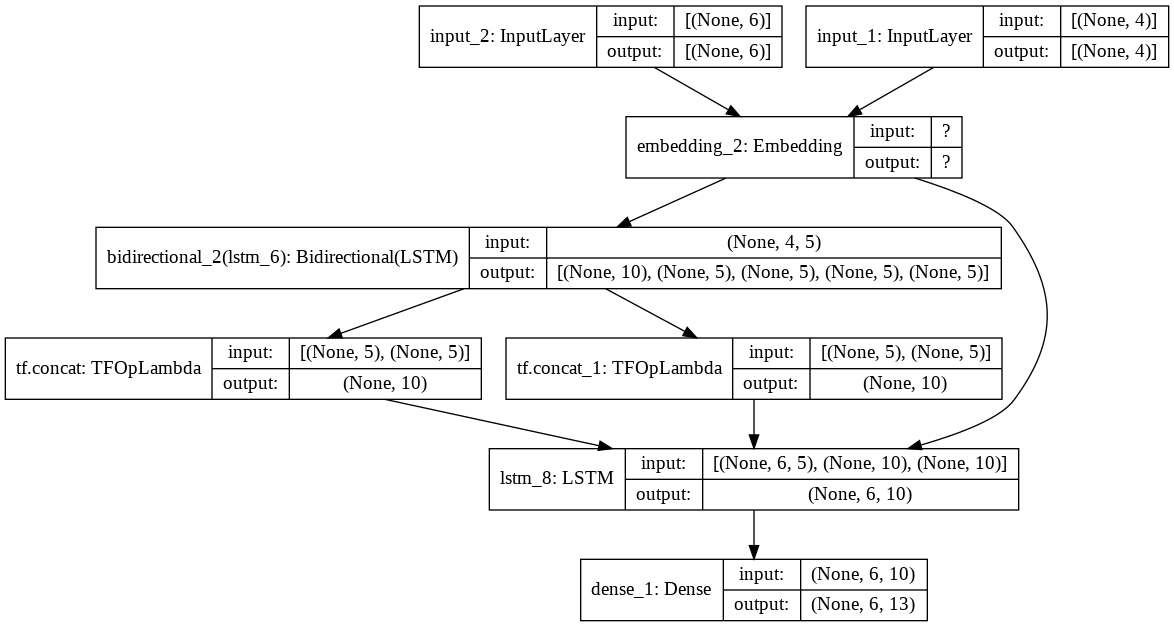

In [25]:
# 모델 생성
model = build_model(len(id_to_word), 5, 4, 6)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 다운로드
- https://github.com/songys/Chatbot_data

In [ ]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

In [ ]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./')

In [ ]:
# 파일 이동
shutil.move('ChatbotData.csv', os.path.join(songys_dir, 'ChatbotData.csv'))
os.listdir(songys_dir)

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# 데이터 분석

In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'), delimiter=',')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

## Char

### Q

In [ ]:
# char 길이 데이터
char_len = df_train['Q'].astype("str").apply(len)
char_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=60, range=[0, 60], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

### A

In [ ]:
# char 길이 데이터
char_len = df_train['A'].astype("str").apply(len)
char_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=80, range=[0, 80], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

### Q

In [ ]:
# word 길이 데이터
word_len = df_train['Q'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=15, range=[0, 15], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

### A

In [ ]:
# word 길이 데이터
word_len = df_train['A'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=21, range=[0, 21], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

### Q

In [ ]:
# word 길이 데이터
spm_len = df_train['Q'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=26, range=[0, 26], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

### A

In [ ]:
# word 길이 데이터
spm_len = df_train['A'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=35, range=[0, 35], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Word Cloud

In [ ]:
# data 합치기
train_set = pd.Series(df_train['Q'].tolist() + df_train['A'].tolist()).astype(str)
train_set.head(10)

In [ ]:
# train review documents
train_review = [review for review in train_set if type(review) is str]
train_review[:10]

In [ ]:
' '.join(train_review[:10])

In [ ]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Loss & Acc

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Sample Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

In [ ]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        ###########################################
        ###########################################
    return enc_inputs, dec_inputs, labels

In [ ]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=400,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [ ]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    #####################################
    #####################################

In [ ]:
string = '너는 누구니'
do_chat(vocab, model, n_enc_seq, n_dec_seq, string)

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

# All Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        # print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_ids_q = tokens_ids_q[:n_enc_max]
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = tokens_ids_a[:n_dec_max]
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        # print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        # print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [ ]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

In [ ]:
train_enc_inputs.shape, train_dec_inputs.shape, train_labels.shape

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=10)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [ ]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')